In [76]:
# coding: utf-8
"""
Hyperoptでパラメータチューニングするためのサンプル
"""
from collections import Counter

import numpy as np

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.metrics import f1_score

from hyperopt import hp, tpe, Trials, fmin

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# データの取得 & 整形

In [57]:
num_x = 1200

digits = load_digits(n_class=10)

data = digits['data']
data /= np.max(digits['data'])
target = digits['target']

x_train, x_test = data[:num_x], data[num_x:]
y_train, y_test = target[:num_x], target[num_x:]

print ('学習用データ', sorted([(key, value) for key, value in Counter(y_train).items()], key=lambda x:x[0]))
print ('チューニング用データ', sorted([(key, value) for key, value in Counter(y_test).items()], key=lambda x:x[0]))

学習用データ [(0, 119), (1, 121), (2, 117), (3, 121), (4, 120), (5, 123), (6, 120), (7, 118), (8, 119), (9, 122)]
チューニング用データ [(0, 59), (1, 61), (2, 60), (3, 62), (4, 61), (5, 59), (6, 61), (7, 61), (8, 55), (9, 58)]


# HyperOptを使用するための関数の定義

In [203]:
hyperopt_parameters = {
    'C': hp.loguniform('C', -8, 2),
    'gamma': hp.loguniform('gamma', -8, 2),
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid'])
}

def objective(args):
    classifier = SVC(**args)
    classifier.fit(x_train, y_train)
    predicts = classifier.predict(x_test)
    f1 = f1_score(y_test, predicts, average='micro')
    return -1*f1

# HyperOptの実行

In [206]:
max_evals = 200
trials = Trials()

best = fmin(
    objective,
    hyperopt_parameters,
    algo=tpe.suggest,
    max_evals=max_evals,
    trials=trials,
    verbose=1
)

In [254]:
best

{'C': 1.61749553623185, 'gamma': 0.23056607283675354, 'kernel': 0}

# 結果の出力

## loguniformの場合

ベストスコア
---------------------
micro_f1:  0.9698492462311558
C:  1.61749553623185
gamma:  0.23056607283675354
kernel:  rbf
---------------------


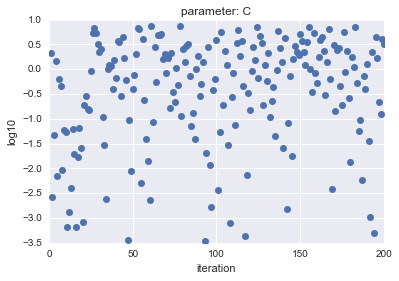

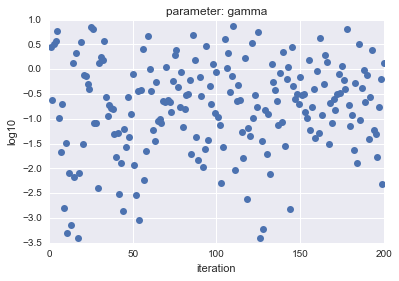

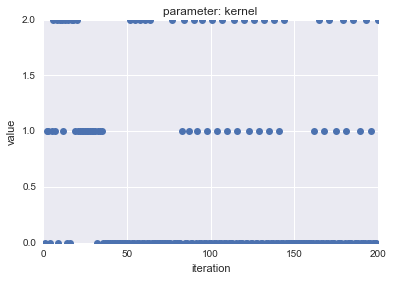

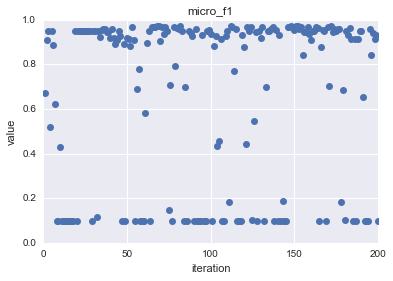

In [207]:
print ('ベストスコア')
print ('---------------------')
print ('micro_f1: ', -1*trials.best_trial['result']['loss'])
print ('C: ', best['C'])
print ('gamma: ', best['gamma'])
print ('kernel: ', ['rbf', 'poly', 'sigmoid'][best['kernel']])
print ('---------------------')

plt.plot(range(1, max_evals+1), np.log10(trials.vals['C']), 'o')
plt.xlabel('iteration')
plt.ylabel('log10')
plt.title('parameter: C')
plt.show()

plt.plot(range(1, max_evals+1), np.log10(trials.vals['gamma']), 'o')
plt.xlabel('iteration')
plt.ylabel('log10')
plt.title('parameter: gamma')
plt.show()

plt.plot(range(1, max_evals+1), trials.vals['kernel'], 'o')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('parameter: kernel')
plt.show()

plt.plot(range(1, max_evals+1), -1*np.array(trials.losses()), 'o')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('micro_f1')
plt.show()

## uniformの場合

ベストスコア
---------------------
micro_f1:  0.9698492462311558
C:  1.692762778703564
gamma:  0.27674222360377465
kernel:  rbf
---------------------


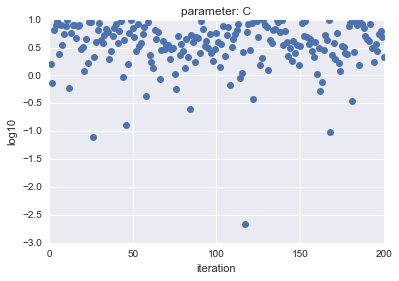

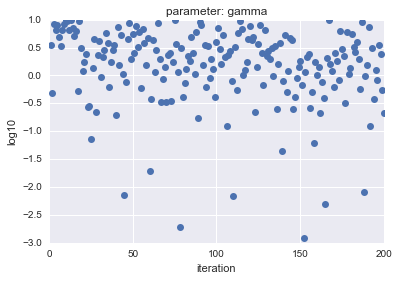

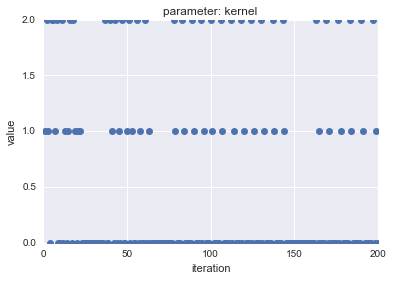

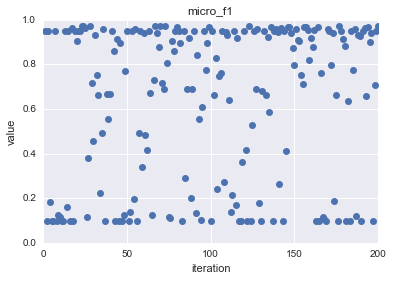

In [202]:
print ('ベストスコア')
print ('---------------------')
print ('micro_f1: ', -1*trials.best_trial['result']['loss'])
print ('C: ', best['C'])
print ('gamma: ', best['gamma'])
print ('kernel: ', ['rbf', 'poly', 'sigmoid'][best['kernel']])
print ('---------------------')

plt.plot(range(1, max_evals+1), np.log10(trials.vals['C']), 'o')
plt.xlabel('iteration')
plt.ylabel('log10')
plt.title('parameter: C')
plt.show()

plt.plot(range(1, max_evals+1), np.log10(trials.vals['gamma']), 'o')
plt.xlabel('iteration')
plt.ylabel('log10')
plt.title('parameter: gamma')
plt.show()

plt.plot(range(1, max_evals+1), trials.vals['kernel'], 'o')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('parameter: kernel')
plt.show()

plt.plot(range(1, max_evals+1), -1*np.array(trials.losses()), 'o')
plt.xlabel('iteration')
plt.ylabel('value')
plt.title('micro_f1')
plt.show()

# LogUniformとUniformの精度の比較

In [209]:
num_epoch = 100
num_iter = 50

f1s_l = []
f1s_u = []

for epoch in range(1, num_epoch+1):
    hyperopt_parameters = {
    'C': hp.loguniform('C', -8, 2),
    'gamma': hp.loguniform('gamma', -8, 2),
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid'])
    }
    f1_l = hyperopt_search(num_iter)
    f1s_l.append(f1_l)

for epoch in range(1, num_epoch+1):
    hyperopt_parameters = {
    'C': hp.uniform('C', 0, 10),
    'gamma': hp.uniform('gamma', 0, 10),
    'kernel': hp.choice('kernel', ['rbf', 'poly', 'sigmoid'])
    }
    f1_u = hyperopt_search(num_iter)
    f1s_u.append(f1_u)

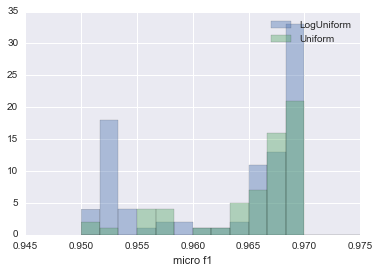

In [211]:
plt.hist(f1s_l, bins=15, range=(0.95, 0.975), alpha=0.4, label='LogUniform')
plt.hist(f1s_u, bins=15, range=(0.95, 0.975), alpha=0.4, label='Uniform')
plt.xlabel('micro f1')
plt.legend()
plt.show()

# Random Searchとの比較

## 実行時間の計測

### random_searchの実行時間

In [213]:
num_iter = 200

def random_search(num_iter):
    results = []
    for _ in range(num_iter):
        random_params = {
            'C': np.exp(np.random.uniform(-8, 2)),
            'gamma': np.exp(np.random.uniform(-8, 2)),
            'kernel': str(np.random.choice(['rbf', 'poly', 'sigmoid']))
        }
        classifier = SVC(**random_params)
        classifier.fit(x_train, y_train)
        predicts = classifier.predict(x_test)
        f1 = f1_score(y_test, predicts, average='micro')
        results.append((f1, random_params))
    return sorted(results, key=lambda x:x[0], reverse=True)[0]

%timeit random_search(num_iter)

1 loop, best of 3: 46 s per loop


### HyperOptの実行時間

In [156]:
max_evals = 200

def hyperopt_search(max_evals):
    trials = Trials()
    best = fmin(objective, hyperopt_parameters, algo=tpe.suggest, max_evals=max_evals, trials=trials)
    return -1*trials.best_trial['result']['loss']

%timeit hyperopt_search(max_evals)

1 loop, best of 3: 32.1 s per loop


## 精度の比較

In [172]:
num_epoch = 100
num_iter = 50

f1s_h = []
f1s_r = []

for epoch in range(1, num_epoch+1):
    f1_hyperopt = hyperopt_search(num_iter)
    f1_random, _ = random_search(num_iter)
    f1s_h.append(f1_hyperopt)
    f1s_r.append(f1_random)

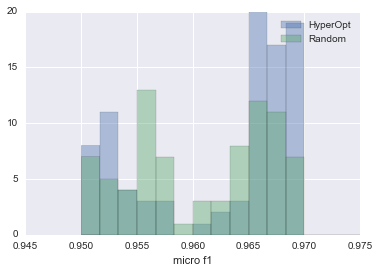

In [212]:
plt.hist(f1s_h, bins=15, range=(0.95, 0.975), alpha=0.4, label='HyperOpt')
plt.hist(f1s_r, bins=15, range=(0.95, 0.975), alpha=0.4, label='Random')
plt.xlabel('micro f1')
plt.legend()
plt.show()

# 図の作成

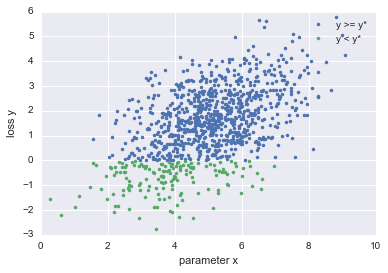

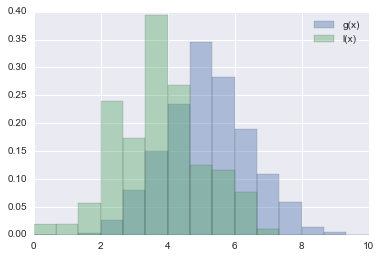

In [253]:
mu = [5, 1.5]
cov = [[2,1],[1,2]]
xs,ys = np.random.multivariate_normal(mu,cov,1000).T
xs1, ys1 = [x for x, y in zip(xs, ys) if y >=0], [y for x, y in zip(xs, ys) if y >=0]
xs2, ys2 = [x for x, y in zip(xs, ys) if y < 0], [y for x, y in zip(xs, ys) if y < 0]

plt.plot(xs1, ys1, '.', label='y >= y*')
plt.plot(xs2, ys2, '.', label='y < y*')
plt.legend()
plt.xlabel('parameter x')
plt.ylabel('loss y')
plt.show()

plt.hist(xs1, label='g(x)', alpha=0.4, bins=15, range=(0, 10), normed=True)
plt.hist(xs2, label='l(x)', alpha=0.4, bins=15, range=(0, 10), normed=True)
plt.legend()
plt.show()